# Case Study

## Goals

Our goals for this case study include the following:
   * Visualize correlations across the dataset
   * Create a combination of gold and copper that can be used as a feature to predict long dated treasuries
   * Run stationarity and cointegration tests
   * Run OLS to test predicatability
   * Create, backtest, and visualize a pairs trading strategy

In [1]:
# import packages and libraries

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
import hvplot.pandas
import holoviews as hv
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

import plotly.graph_objects as go
from plotly.subplots import make_subplots


C:\Users\Alex\anaconda3\envs\pyvizenv2\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Alex\anaconda3\envs\pyvizenv2\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Alex\anaconda3\envs\pyvizenv2\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)



Bad key savefig.frameon in file C:\Users\Alex\anaconda3\envs\pyvizenv2\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\Users\Alex\anaconda3\envs\pyvizenv2\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\Users\Alex\anaconda3\envs\pyvizenv2\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probab

In [2]:
# import and clean raw data

from pathlib import Path

data_path = Path('../Resources/Assignment Data (Quant Strategist - Los Angelesl).csv')
raw_data = pd.read_csv(data_path, header=3, index_col='Date', encoding='cp1252')
raw_data = raw_data.loc[:, ~raw_data.columns.str.contains('^Unnamed')]
raw_data.dropna(inplace=True)
raw_data.index = pd.to_datetime(raw_data.index)

# remove commas from column headers

colList = []

for col in raw_data.columns:
    colList.append(col.replace(',', ''))
    
raw_data.columns = colList
    

In [3]:
# Add Gold/Copper Index to dataframe

data = raw_data
data['Gold/Copper Index'] = data['Gold Price Index'] / data['Copper Price Index']

# Add duration balanced 10 & 30 year index to dataframe
data['10 + 30 Year Excess Return Index'] = data['United States 10 Year Treasury Note Constant Maturity Excess Return Index (Excess of Cash)'] + data['United States 30 Year Treasury Bond Constant Maturity Excess Return Index (Excess of Cash)'] * (data['United States 10 year Treasury Modified Duration'] / data['United States 30 year Treasury Modified Duration'])

# remove commas from column headers



data.head()

Gold Price Index  Copper Price Index  \
Date                                               
2000-06-09            290.78               80.37   
2000-06-12            293.22               80.11   
2000-06-13            291.98               80.86   
2000-06-14            297.83               81.72   
2000-06-15            295.69               82.54   

            Gold Excess Return Index (Excess of Cash)  \
Date                                                    
2000-06-09                                      44.94   
2000-06-12                                      45.35   
2000-06-13                                      45.20   
2000-06-14                                      46.14   
2000-06-15                                      45.81   

            Copper Excess Return Index  (Excess of Cash)  \
Date                                                       
2000-06-09                                        111.00   
2000-06-12                                        110.57   
2000-06-13                                        111.54   
2000-06-14                                        112.63   
2000-06-15                                        113.77   

            United States 10 Year Treasury Note Constant Maturity Total Return Index  \
Date                                                                                   
2000-06-09                                             261.12                          
2000-06-12                                             261.86                          
2000-06-13                                             261.48                          
2000-06-14                                             262.54                          
2000-06-15                                             262.62                          

            United States 30 Year Treasury Bond Constant Maturity Total Return Index   \
Date                                                                                    
2000-06-09                                             283.57                           
2000-06-12                                             283.99                           
2000-06-13                                             281.52                           
2000-06-14                                             282.70                           
2000-06-15                                             282.20                           

            Treasury Repo Rate  \
Date                             
2000-06-09                6.64   
2000-06-12                6.65   
2000-06-13                6.65   
2000-06-14                6.58   
2000-06-15                6.65   

            United States 10 Year Treasury Note Constant Maturity Excess Return Index (Excess of Cash)  \
Date                                                                                                     
2000-06-09                                             100.00                                            
2000-06-12                                             100.26                                            
2000-06-13                                             100.09                                            
2000-06-14                                             100.47                                            
2000-06-15                                             100.47                                            

            United States 30 Year Treasury Bond Constant Maturity Excess Return Index (Excess of Cash)  \
Date                                                                                                     
2000-06-09                                             100.00                                            
2000-06-12                                             100.12                                            
2000-06-13                                              99.23                                            
2000-06-14                                              99.62            

In [4]:
# Create a dataframe of daily returns and a dataframe of log returns, where applicable

returns = data.copy()
log_returns = data.copy()

for col in returns.columns:
    if returns.columns.get_loc(col) < 6 or returns.columns.get_loc(col) == 7 or returns.columns.get_loc(col) == 8 or returns.columns.get_loc(col) == 13:
        returns[col] = returns[col].pct_change()
        
returns.dropna(axis=0, inplace=True)

for col in returns.columns:
    if returns.columns.get_loc(col) < 6 or returns.columns.get_loc(col) == 7 or returns.columns.get_loc(col) == 8 or returns.columns.get_loc(col) == 13:
        log_returns[col] = np.log(1+returns[col])

log_returns.dropna(inplace=True)

returns.head()

Gold Price Index  Copper Price Index  \
Date                                               
2000-06-12          0.008391           -0.003235   
2000-06-13         -0.004229            0.009362   
2000-06-14          0.020036            0.010636   
2000-06-15         -0.007185            0.010034   
2000-06-16         -0.003652            0.007027   

            Gold Excess Return Index (Excess of Cash)  \
Date                                                    
2000-06-12                                   0.009123   
2000-06-13                                  -0.003308   
2000-06-14                                   0.020796   
2000-06-15                                  -0.007152   
2000-06-16                                  -0.003711   

            Copper Excess Return Index  (Excess of Cash)  \
Date                                                       
2000-06-12                                     -0.003874   
2000-06-13                                      0.008773   
2000-06-14                                      0.009772   
2000-06-15                                      0.010122   
2000-06-16                                      0.007120   

            United States 10 Year Treasury Note Constant Maturity Total Return Index  \
Date                                                                                   
2000-06-12                                           0.002834                          
2000-06-13                                          -0.001451                          
2000-06-14                                           0.004054                          
2000-06-15                                           0.000305                          
2000-06-16                                           0.005559                          

            United States 30 Year Treasury Bond Constant Maturity Total Return Index   \
Date                                                                                    
2000-06-12                                           0.001481                           
2000-06-13                                          -0.008697                           
2000-06-14                                           0.004192                           
2000-06-15                                          -0.001769                           
2000-06-16                                           0.007477                           

            Treasury Repo Rate  \
Date                             
2000-06-12                6.65   
2000-06-13                6.65   
2000-06-14                6.58   
2000-06-15                6.65   
2000-06-16                6.65   

            United States 10 Year Treasury Note Constant Maturity Excess Return Index (Excess of Cash)  \
Date                                                                                                     
2000-06-12                                           0.002600                                            
2000-06-13                                          -0.001696                                            
2000-06-14                                           0.003797                                            
2000-06-15                                           0.000000                                            
2000-06-16                                           0.005275                                            

            United States 30 Year Treasury Bond Constant Maturity Excess Return Index (Excess of Cash)  \
Date                                                                                                     
2000-06-12                                           0.001200                                            
2000-06-13                                          -0.008889                                            
2000-06-14                                           0.003930                                            
2000-06-15                                          -0.002008            

In [5]:
# visualize yields vs. gold/copper index to confirm hypothesis of inverse relationship

data.hvplot(x='Date', y=['Gold/Copper Index', 'United States 10 year Treasury Mid Yield', 'United States 30 year Treasury Mid Yield'])

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

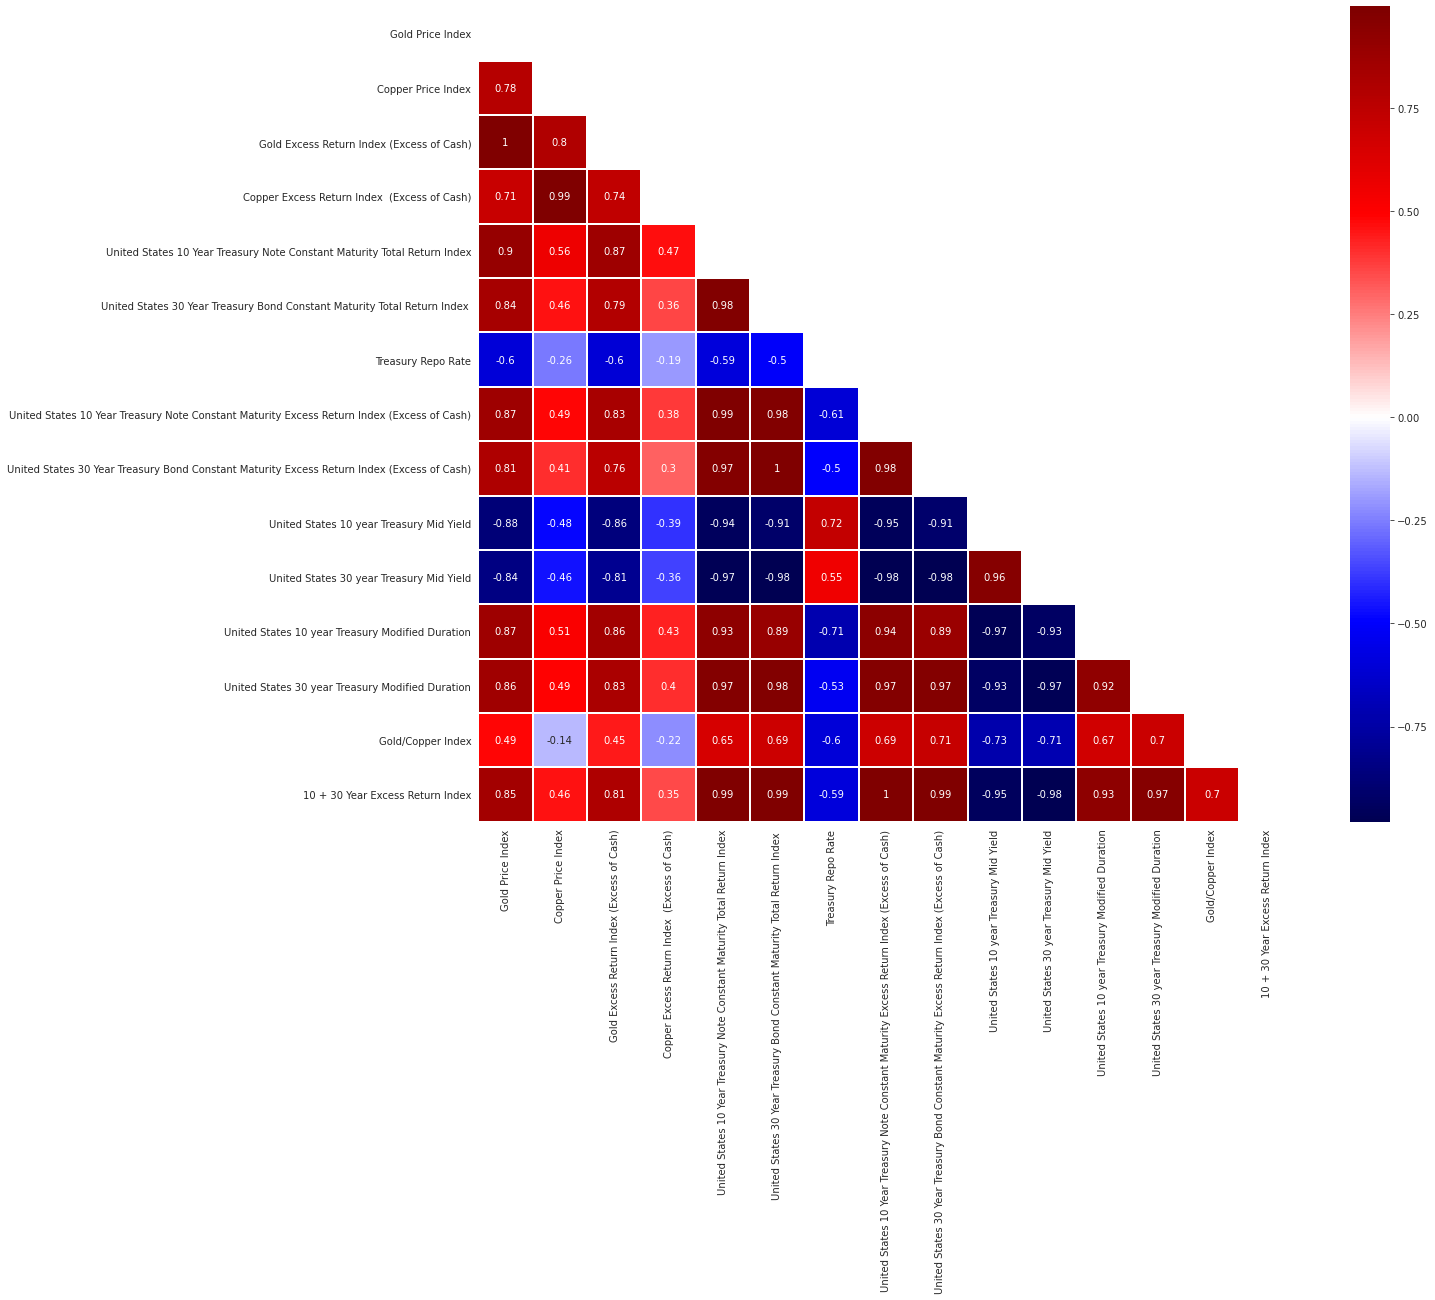

In [6]:
# visualize correlation matrix

corrM = data.corr()

mask = np.zeros_like(corrM)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 15))
    ax = sns.heatmap(corrM, mask=mask, center=0, annot=True, square=True, linewidths=1, cmap="seismic")

In [7]:
# Alternatively, we can view just the Gold/Copper Index correlations

corrM['Gold/Copper Index'].iloc[:-1].hvplot.barh() + corrM['Gold/Copper Index'].iloc[:-1].hvplot.table(width=200)

:Layout
   .Bars.Gold_over_Copper_Index :Bars   [index]   (Gold/Copper Index)
   .Table.I                     :Table   [Gold/Copper Index]

In [8]:
# create X (feature dataframe) using appropriate features
# attempt to eliminate colinear features to prevent spurious regression

lr_features = data.drop(labels={'Gold Price Index', 'Copper Price Index',
       'United States 10 Year Treasury Note Constant Maturity Total Return Index',
       'United States 30 Year Treasury Bond Constant Maturity Total Return Index ',
       'United States 10 Year Treasury Note Constant Maturity Excess Return Index (Excess of Cash)',
       'United States 30 Year Treasury Bond Constant Maturity Excess Return Index (Excess of Cash)',
       'United States 10 year Treasury Mid Yield',
       'United States 30 year Treasury Mid Yield',
       'United States 10 year Treasury Modified Duration',
       'United States 30 year Treasury Modified Duration', 'Gold/Copper Index', 'Treasury Repo Rate', '10 + 30 Year Excess Return Index'}, axis=1)

lr_features.head()

Gold Excess Return Index (Excess of Cash)  \
Date                                                    
2000-06-09                                      44.94   
2000-06-12                                      45.35   
2000-06-13                                      45.20   
2000-06-14                                      46.14   
2000-06-15                                      45.81   

            Copper Excess Return Index  (Excess of Cash)  
Date                                                      
2000-06-09                                        111.00  
2000-06-12                                        110.57  
2000-06-13                                        111.54  
2000-06-14                                        112.63  
2000-06-15                                        113.77

In [9]:
# OLS

lr_model = LinearRegression()

X = lr_features.iloc[:3000]
y = data['10 + 30 Year Excess Return Index'].iloc[:3000].to_frame()
lr_model.fit(X, y)
test = X

predictions = lr_model.predict(X)
predictions

# Calculate r2_score (r-squared)
r2 = r2_score(y, predictions)

# Calculate mean squared error 
mse = mean_squared_error(y, predictions)

# Using mean squared error above, calculate root-mean-squared error (RMSE)
rmse = np.sqrt(mse)

# Print the r2, mser, rmse, and standard deviation
print(f"R-squared (R2 ): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Standard Deviation: {np.std(y)}")

# with statsmodels print detailed reults

X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

R-squared (R2 ): 0.8226141406133471
Mean Squared Error (MSE): 116.1702817441924
Root Mean Squared Error (RMSE): 10.778231846837977
Standard Deviation: 10 + 30 Year Excess Return Index    25.591045
dtype: float64
                                   OLS Regression Results                                   
Dep. Variable:     10 + 30 Year Excess Return Index   R-squared:                       0.823
Model:                                          OLS   Adj. R-squared:                  0.822
Method:                               Least Squares   F-statistic:                     6949.
Date:                              Fri, 29 Oct 2021   Prob (F-statistic):               0.00
Time:                                      15:29:32   Log-Likelihood:                -11389.
No. Observations:                              3000   AIC:                         2.278e+04
Df Residuals:                                  2997   BIC:                         2.280e+04
Df Model:                                   

In [65]:
# Plot our regression generated Gold/Copper weighted combination against our 10 + 30 Year Treasury Index

train = lr_features[:3000].copy()
train['Gold + Copper Excess Return Index'] = 152.4777 + train['Gold Excess Return Index (Excess of Cash)'] * 0.6688 +  train['Copper Excess Return Index  (Excess of Cash)'] * -0.0517

train['10 + 30 Year Excess Return Index'] = data['10 + 30 Year Excess Return Index'].iloc[:3000]

train.hvplot(x='Date', y=['Gold + Copper Excess Return Index', '10 + 30 Year Excess Return Index'], grid=True)


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [66]:
# Test for cointegration

def cointegration(a, b):
  if ts.coint(a, b)[1] < 0.10:
    print('The series are cointegrated')
    print('p-value = ', ts.coint(a, b)[1])
  else:
    print('The series are NOT cointegrated')
    print('p-value = ', ts.coint(a, b)[1])

cointegration(train['10 + 30 Year Excess Return Index'], train['Gold + Copper Excess Return Index'])

The series are cointegrated
p-value =  0.0612202752984476


In [67]:
# Calculate and plot the spread 

train['Spread'] = train['Gold + Copper Excess Return Index'] - train['10 + 30 Year Excess Return Index']
zero_line = hv.HLine(0)
zero_line.opts(color = 'black', line_dash = 'dashed', line_width=2.0)

plot = train.hvplot(x='Date', y=['Spread'], grid=True)
plot * zero_line

:Overlay
   .Curve.I :Curve   [Date]   (Spread)
   .HLine.I :HLine   [x,y]

In [68]:
# We can alo examine the ratio

train['Ratio'] = train['Gold + Copper Excess Return Index'] / train['10 + 30 Year Excess Return Index']

one_line = hv.HLine(1)
one_line.opts(color = 'black', line_dash = 'dashed', line_width=2.0)

ratio_plot = train.hvplot(x='Date', y=['Ratio'], grid=True)
ratio_plot * one_line



:Overlay
   .Curve.I :Curve   [Date]   (Ratio)
   .HLine.I :HLine   [x,y]

In [69]:
# Check for stationarity in the spread and ratio

def stationarity(a, cutoff = .05):
    a = np.ravel(a)
    if ts.adfuller(a)[1] < cutoff:
        print('The series is stationary')
        print('p-value = ', ts.adfuller(a)[1])
    else:
        print('The series is NOT stationary')
        print('p-value = ', ts.adfuller(a)[1])

stationarity(train['Spread'])
stationarity(train['Ratio'])

The series is stationary
p-value =  0.016920769141859374
The series is stationary
p-value =  0.02040770574810412


In [70]:
# Plot z-scores of the ratio

def zscore(series):
    return (series - series.mean()) / np.std(series)

train['Z-Score'] = zscore(train['Ratio'])

zscore_plot = train.hvplot(x='Date', y=['Z-Score'])
z_zero_line = hv.HLine(0)
z_zero_line.opts(color = 'black', line_dash = 'dashed', line_width=2.0)
z_plus_one = hv.HLine(1)
z_plus_one.opts(color = 'red', line_dash = 'dashed', line_width=2.0)
z_minus_one = hv.HLine(-1)
z_minus_one.opts(color = 'green', line_dash = 'dashed', line_width=2.0)

zscore_plot * z_zero_line * z_plus_one * z_minus_one

:Overlay
   .Curve.I   :Curve   [Date]   (Z-Score)
   .HLine.I   :HLine   [x,y]
   .HLine.II  :HLine   [x,y]
   .HLine.III :HLine   [x,y]

In [80]:
train

Gold Excess Return Index (Excess of Cash)  \
Date                                                    
2000-06-09                                      44.94   
2000-06-12                                      45.35   
2000-06-13                                      45.20   
2000-06-14                                      46.14   
2000-06-15                                      45.81   
...                                               ...   
2012-05-31                                     176.98   
2012-06-01                                     183.53   
2012-06-04                                     182.60   
2012-06-05                                     182.94   
2012-06-06                                     184.89   

            Copper Excess Return Index  (Excess of Cash)  \
Date                                                       
2000-06-09                                        111.00   
2000-06-12                                        110.57   
2000-06-13                                        111.54   
2000-06-14                                        112.63   
2000-06-15                                        113.77   
...                                                  ...   
2012-05-31                                        478.64   
2012-06-01                                        471.32   
2012-06-04                                        470.43   
2012-06-05                                        467.87   
2012-06-06                                        480.56   

            Gold + Copper Excess Return Index  \
Date                                            
2000-06-09                         176.794872   
2000-06-12                         177.091311   
2000-06-13                         176.940842   
2000-06-14                         177.513161   
2000-06-15                         177.233519   
...                                       ...   
2012-05-31                         246.096236   
2012-06-01                         250.855320   
2012-06-04                         250.279349   
2012-06-05                         250.639093   
2012-06-06                         251.287180   

            10 + 30 Year Excess Return Index     Spread     Ratio   Z-Score  
Date                                                                         
2000-06-09                        150.870827  25.924045  1.171829  2.867183  
2000-06-12                        151.191872  25.899439  1.171302  2.858195  
2000-06-13                        150.754478  26.186364  1.173702  2.899085  
2000-06-14                        151.295051  26.218110  1.173291  2.892087  
2000-06-15                        151.229956  26.003563  1.171947  2.869189  
...                                      ...        ...       ...       ...  
2012-05-31                        271.398682 -25.302446  0.906770 -1.648345  
2012-06-01                        275.093994 -24.238674  0.911889 -1.561133  
2012-06-04                        273.590914 -23.311565  0.914794 -1.511651  
2012-06-05                        272.426992 -21.787899  0.920023 -1.422572  
2012-06-06                        269.385952 -18.098772  0.932815 -1.204653  

[3000 rows x 7 columns]

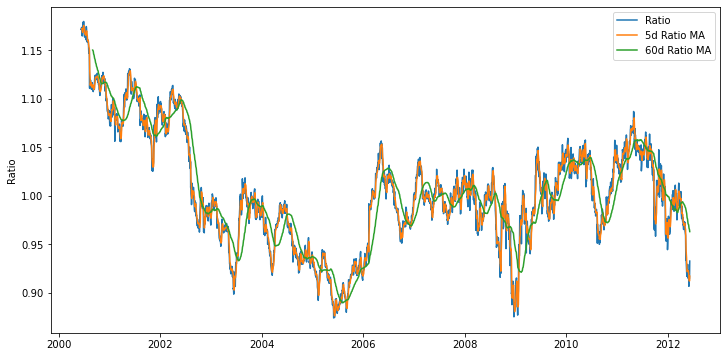

In [82]:
# Feature Engineering for training

feature_train = train['Ratio']

ratios_mavg5 = feature_train.rolling(window=5, center=False).mean()
ratios_mavg60 = feature_train.rolling(window=60, center=False).mean()
std_60 = feature_train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(feature_train.index, feature_train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])
plt.ylabel('Ratio')
    
plt.show()


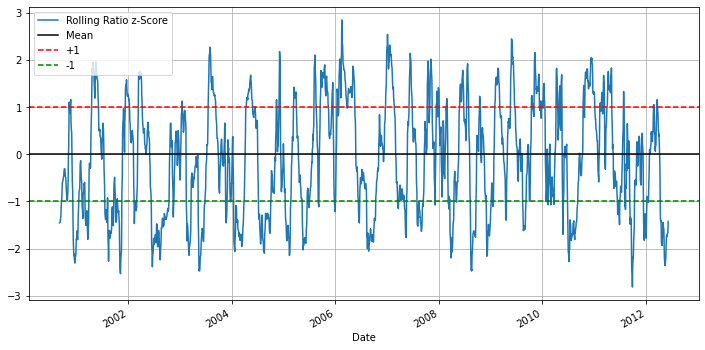

In [83]:
plt.figure(figsize=(12,6))
zscore_60_5.plot(grid=True)
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

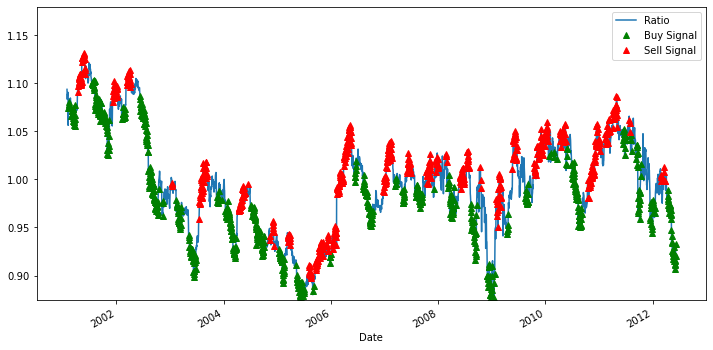

In [85]:
plt.figure(figsize=(12,6))

feature_train[160:].plot()
buy = feature_train.copy()
sell = feature_train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, train['Ratio'].min(), train['Ratio'].max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

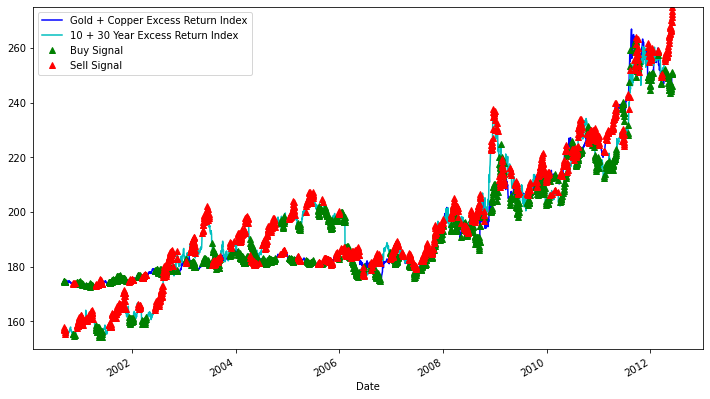

In [86]:
plt.figure(figsize=(12,7))
S1 = train['Gold + Copper Excess Return Index'].iloc[:3000]
S2 = train['10 + 30 Year Excess Return Index'].iloc[:3000]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy x and sell y
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell x and buy y
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))

plt.legend(['Gold + Copper Excess Return Index', '10 + 30 Year Excess Return Index', 'Buy Signal', 'Sell Signal'])
plt.show()

In [87]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
            
            
    return money

In [88]:
trade(train['Gold + Copper Excess Return Index'], train['10 + 30 Year Excess Return Index'], 60, 5)

4071.086190995511

In [89]:
# Now we look to test our system outside of training data
# Plot our regression generated Gold/Copper weighted combination against our 10 + 30 Year Treasury Index

test = lr_features[3001:].copy()
test['Gold + Copper Excess Return Index'] = 152.4777 + test['Gold Excess Return Index (Excess of Cash)'] * 0.6688 +  test['Copper Excess Return Index  (Excess of Cash)'] * -0.0517

test['10 + 30 Year Excess Return Index'] = data['10 + 30 Year Excess Return Index']

test.hvplot(x='Date', y=['Gold + Copper Excess Return Index', '10 + 30 Year Excess Return Index'], grid=True)



:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [90]:
# Calculate and plot the spread 

test['Spread'] = test['Gold + Copper Excess Return Index'] - test['10 + 30 Year Excess Return Index']
mean_line = hv.HLine(np.mean(test['Spread']))
mean_line.opts(color = 'black', line_dash = 'dashed', line_width=2.0)

test_plot = test.hvplot(x='Date', y=['Spread'], grid=True)
test_plot * mean_line

:Overlay
   .Curve.I :Curve   [Date]   (Spread)
   .HLine.I :HLine   [x,y]

In [91]:
# We can alo examine the ratio

test['Ratio'] = test['Gold + Copper Excess Return Index'] / test['10 + 30 Year Excess Return Index']

ratio_mean_line = hv.HLine(np.mean(test['Ratio']))
ratio_mean_line.opts(color = 'black', line_dash = 'dashed', line_width=2.0)

ratio_plot = test.hvplot(x='Date', y=['Ratio'], grid=True)
ratio_plot * ratio_mean_line


:Overlay
   .Curve.I :Curve   [Date]   (Ratio)
   .HLine.I :HLine   [x,y]

In [92]:
# Plot z-scores of the ratio

test['Z-Score'] = zscore(test['Ratio'])

zscore_plot = test.hvplot(x='Date', y=['Z-Score'])
z_zero_line = hv.HLine(0)
z_zero_line.opts(color = 'black', line_dash = 'dashed', line_width=2.0)
z_plus_one = hv.HLine(1)
z_plus_one.opts(color = 'red', line_dash = 'dashed', line_width=2.0)
z_minus_one = hv.HLine(-1)
z_minus_one.opts(color = 'green', line_dash = 'dashed', line_width=2.0)

zscore_plot * z_zero_line * z_plus_one * z_minus_one

:Overlay
   .Curve.I   :Curve   [Date]   (Z-Score)
   .HLine.I   :HLine   [x,y]
   .HLine.II  :HLine   [x,y]
   .HLine.III :HLine   [x,y]

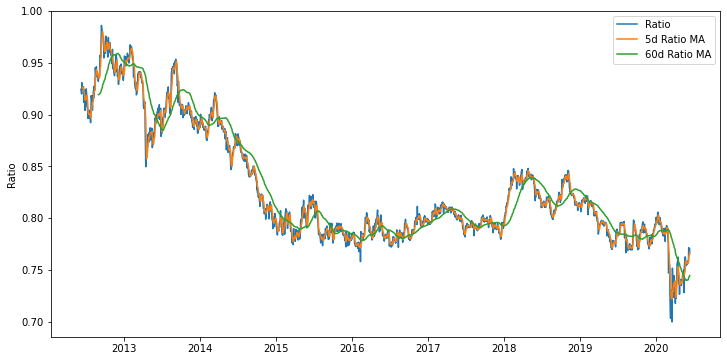

In [95]:
feature_test = test['Ratio']


ratios_mavg5 = feature_test.rolling(window=5, center=False).mean()
ratios_mavg60 = feature_test.rolling(window=60, center=False).mean()
std_60 = feature_test.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(feature_test.index, feature_test.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

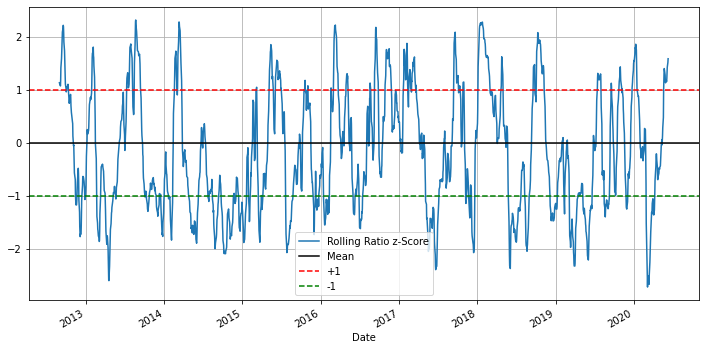

In [96]:
plt.figure(figsize=(12,6))
zscore_60_5.plot(grid=True)
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

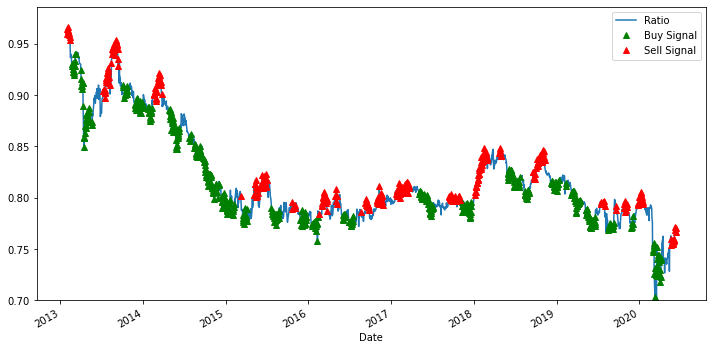

In [97]:
plt.figure(figsize=(12,6))

feature_test[160:].plot()
buy = feature_test.copy()
sell = feature_test.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, test['Ratio'].min(), test['Ratio'].max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

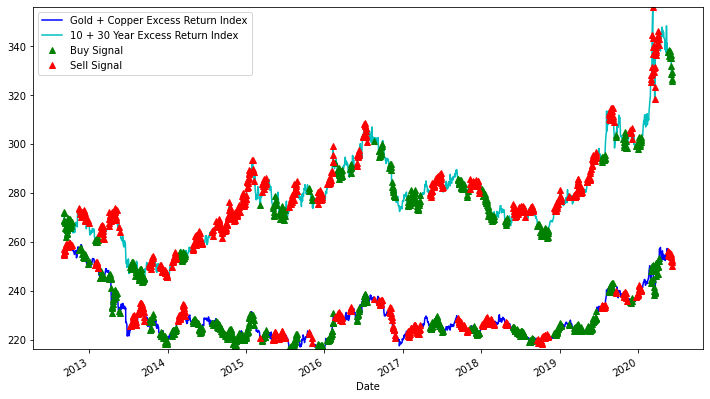

In [99]:
plt.figure(figsize=(12,7))
S1 = test['Gold + Copper Excess Return Index']
S2 = test['10 + 30 Year Excess Return Index']

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy x and sell y
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell x and buy y
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))

plt.legend(['Gold + Copper Excess Return Index', '10 + 30 Year Excess Return Index', 'Buy Signal', 'Sell Signal'])
plt.show()

In [100]:
trade(test['Gold + Copper Excess Return Index'], test['10 + 30 Year Excess Return Index'], 60, 5)

1392.19678608281